A simple notebook for testing a SR model.

# Setup

In [ ]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
import numpy as np
from matplotlib import pyplot as plt
from tqdm.auto import tqdm

In [ ]:
from facedataset import FaceDataset
from metrics import mse_loss, psnr
from utils import inner_pad, clip

In [ ]:
from model import Model

In [ ]:
import PIL
from classic_model import Classic

In [ ]:
batch_size = 64

In [ ]:
train_set = FaceDataset("data/thumbnails128x128", 0, 55000, 32, 64)
train_loader = DataLoader(train_set, batch_size = batch_size, shuffle=True)

In [ ]:
val_set = FaceDataset("data/thumbnails128x128", 55000, 65000, 32, 64)
val_loader = DataLoader(val_set, batch_size = batch_size, shuffle=True)

Ignore test set (65 000 -- 70 000) for now

## Example Batch


In [ ]:
fig, ax = plt.subplots(batch_size, 2)
for lower, higher in train_loader:
    for i in range(batch_size):
        ax[i][0].imshow(lower[i].detach().permute(1,2,0))
        ax[i][1].imshow(higher[i].detach().permute(1,2,0))
        ax[i][0].axis('off')
        ax[i][1].axis('off')
    break
fig.set_size_inches(6, 3*batch_size)
plt.tight_layout()
plt.show()

# Training

In [ ]:
def train_model(model, optimizer):
    model.train()

    lloss = []

    for k, (img, target) in tqdm(enumerate(train_loader), total=len(train_loader)):
        optimizer.zero_grad()
        out = model(img)
        loss = mse_loss(out, target)
        loss.backward()
        optimizer.step()
        lloss.append(loss.detach())
        if k % 15 == 0:
            print(f"{np.mean(lloss):.6f}")
            lloss = []

In [ ]:
# model = Model()

In [20]:
model = Classic(64, PIL.Image.BICUBIC)

## Trainings programm

In [ ]:
# train_model(model, torch.optim.Adam(model.parameters(), 1e-5))

# Evaluation

In [22]:
model.eval()


with torch.no_grad():
    val_psnr = []

    for img, target in tqdm(val_loader):
        out = model(img)
        val_psnr.append(psnr(out, target))
        

    val_psnr = torch.cat(val_psnr)
    print(f"Mean PSNR {torch.mean(val_psnr):.2f} ± {torch.std(val_psnr):.2f}")


Mean PSNR 65.56 ± 3.65


Upscaling side to side with input and original:

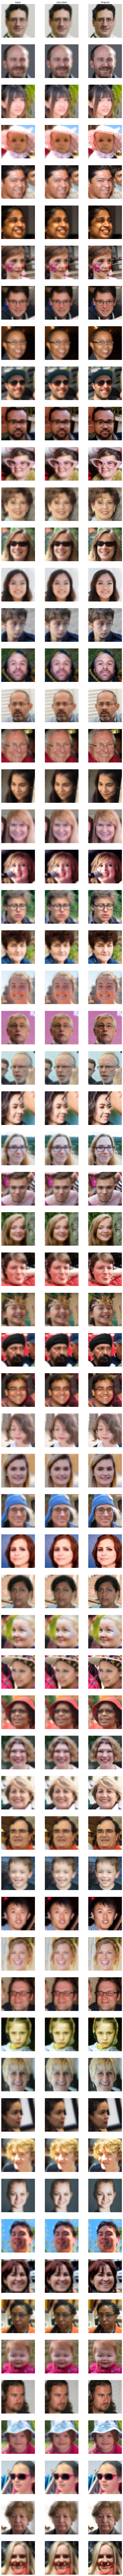

In [21]:
model.eval()

with torch.no_grad():
    it = iter(val_loader)
    img, target = next(it)
    out = clip(model(img))
    
    fig, ax = plt.subplots(batch_size, 3)
    for i in range(batch_size):
        ax[i][0].imshow(img[i].permute(1,2,0))
        ax[i][1].imshow(out[i].permute(1,2,0))
        ax[i][2].imshow(target[i].permute(1,2,0))
        ax[i][0].axis('off')
        ax[i][1].axis('off')
        ax[i][2].axis('off')
    fig.set_size_inches(12, 4*batch_size+1)
    
    ax[0][0].set_title("Input")
    ax[0][1].set_title("Upscaled")
    ax[0][2].set_title("Original")

    plt.show()

Multiple upscalings in succession:

In [ ]:
model.eval()

with torch.no_grad():
    steps = 4
    fig, ax = plt.subplots(2, steps)
    img, target = next(iter(val_loader))
    img, target = img[0], target[0]
    ax[0][0].imshow(img.permute(1,2,0))
    ax[0][-1].imshow(target.permute(1,2,0))
    ax[0][0].axis('off')
    ax[0][-1].axis('off')
    for i in range(1,steps-1):
        fig.delaxes(ax[0][i])

    out = img.unsqueeze(0)
    for k in range(steps):
        out = clip(model(out))
        ax[1][k].imshow(out[0].permute(1,2,0))
        ax[1][k].axis('off')
    
    fig.set_size_inches(4*steps, 8)
    plt.show()